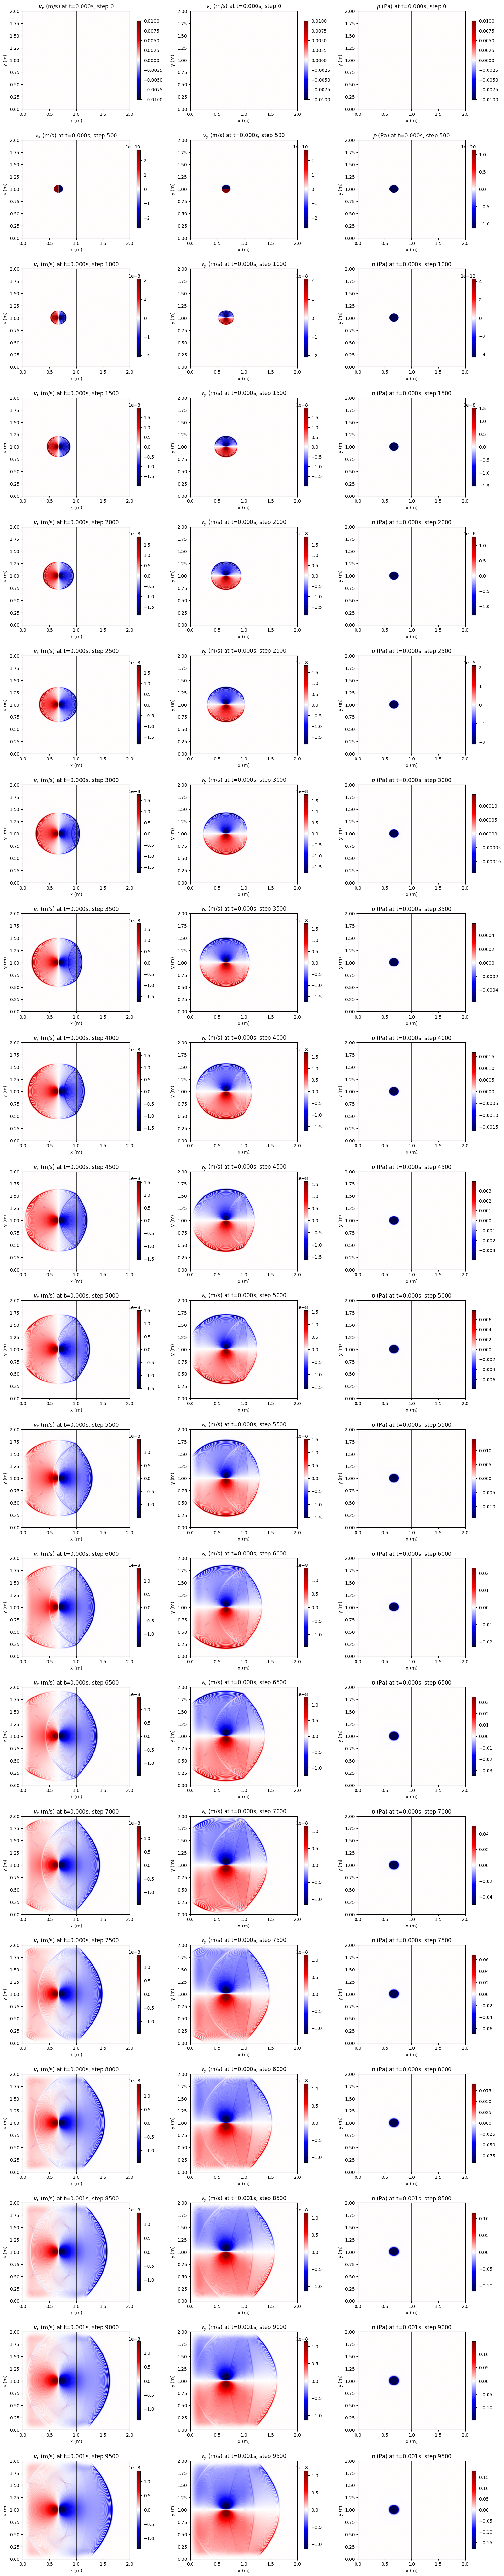

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Configuration Parameters ---
nx, ny = 1000, 1000  # Number of grid points
nt = 10000          # Number of time steps
lx, ly = 2.0, 2.0  # Domain size
plot_interval = 500 # Interval for plotting snapshots
damping_width = 100 # Width of damping layer
damping_strength = 0.1 # Strength of damping

# --- Grid Setup ---
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

def configure_model(config=1):
    """Configures model parameters based on the selected configuration."""
    if config == 1: # Default configuration
        rho_s, rho_f, phi = 2500.0, 1000.0, 0.2  # Solid density, fluid density, porosity
        K_s, K_f = 3e10, 2.2e9                  # Solid bulk modulus, fluid bulk modulus
        K_d_poro, mu_poro = 1e10, 1e9           # Drained bulk & shear moduli (poroelastic)
        K_d_el, mu_el = 5e9, 5e8                # Bulk & shear moduli (elastic)
        f0, source_duration = 50, 0.02          # Source frequency, duration
        geometry = 'split'                      # Geometry of poroelastic region
        source_type = 'ricker'                  # Type of source wavelet
        source_amplitude = 1e8                  # Amplitude of the source
    elif config == 2:
        rho_s, rho_f, phi = 2600.0, 950.0, 0.15
        K_s, K_f = 2.5e10, 2e9
        K_d_poro, mu_poro = 5e9, 2e8
        K_d_el, mu_el = 1e10, 1e9
        f0, source_duration = 100, 0.01
        geometry = 'circle'
        source_type = 'sine'
        source_amplitude = 1e7
    elif config == 3:
        rho_s, rho_f, phi = 2400.0, 1100.0, 0.3
        K_s, K_f = 2e10, 1.5e9
        K_d_poro, mu_poro = 8e9, 6e8
        K_d_el, mu_el = 2e9, 2e7
        f0, source_duration = 75, 0.03
        geometry = 'square'
        source_type = 'ricker'
        source_amplitude = 1e8
    else:
        raise ValueError("Invalid configuration ID")

    # --- Derived Poroelastic Parameters ---

    M = 1 / (phi / K_f + (1 - phi) / K_s - K_d_poro / (K_s**2))
    # Biot-Willis coefficient
    alpha_biot = 1 - K_d_poro / K_s
    kappa = 1e-13  # Permeability
    eta = 1e-3     # Fluid viscosity
    # Bulk density of the poroelastic medium
    rho_poro_bulk = rho_s * (1 - phi) + rho_f * phi

    c_p_diffusivity = kappa * M / eta

    return (rho_s, rho_poro_bulk, K_d_poro, mu_poro, K_d_el, mu_el,
            alpha_biot, c_p_diffusivity, f0, source_duration, geometry,
            source_type, source_amplitude, M)

# --- Apply Configuration ---
(rho_s_val, rho_poro_val, K_d_poro_val, mu_poro_val,
 K_d_el_val, mu_el_val, alpha_biot_coeff, c_p_val,
 f0_val, source_duration_val, geometry_val, source_type_val,
 source_amplitude_val, M_val) = configure_model(config=1)

# --- Define Geometry and Material Properties on Grid ---
if geometry_val == 'circle':
    center_x, center_y = lx / 2, ly / 2
    radius = 0.25
    is_poro = (X - center_x)**2 + (Y - center_y)**2 < radius**2
elif geometry_val == 'split':
    is_poro = X < lx / 2
elif geometry_val == 'square':
    margin = 0.2
    is_poro = (X > margin) & (X < lx - margin) & \
              (Y > margin) & (Y < ly - margin)
else:
    is_poro = np.zeros_like(X, dtype=bool)

# Spatially varying material properties
rho = np.where(is_poro, rho_poro_val, rho_s_val)
K_d = np.where(is_poro, K_d_poro_val, K_d_el_val)
mu = np.where(is_poro, mu_poro_val, mu_el_val)

# --- Stability and Time Step ---

min_rho_positive = np.min(rho[rho > 0]) if np.any(rho > 0) else 1.0 # Fallback to 1.0 if all rho is zero (unlikely here)
vp_max = np.sqrt((np.max(K_d) + 4 * np.max(mu) / 3) / min_rho_positive)
dt = 0.1 * min(dx, dy) / (np.sqrt(2) * vp_max)

# --- Field Initialization ---
vx = np.zeros((nx + 1, ny))      # Velocity x-component
vy = np.zeros((nx, ny + 1))      # Velocity y-component
sxx = np.zeros((nx, ny))         # Stress xx-component
syy = np.zeros((nx, ny))         # Stress yy-component
sxy = np.zeros((nx, ny))         # Stress xy-component
p = np.zeros((nx, ny))           # Pore pressure

# --- Damping Profile (Absorbing Boundary Conditions) ---

damping_profile_x_vx_vals = np.ones(nx + 1)
x_coords_vx = np.linspace(0, lx, nx + 1)
for i in range(damping_width):
    damping_profile_x_vx_vals[i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)
    damping_profile_x_vx_vals[nx - i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)

# For vy (defined at ny+1 points in y)
damping_profile_y_vy_vals = np.ones(ny + 1)
y_coords_vy = np.linspace(0, ly, ny + 1)
for i in range(damping_width):
    damping_profile_y_vy_vals[i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)
    damping_profile_y_vy_vals[ny - i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)

# For p, sxx, syy, sxy (defined at nx points in x, ny points in y)
damping_profile_x_centered_vals = np.ones(nx)
x_coords_centered = x
for i in range(damping_width):
    if i < nx: # Ensure index is within bounds
        damping_profile_x_centered_vals[i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)
    if (nx - 1 - i) >= 0 and (nx-1-i) < nx :
         damping_profile_x_centered_vals[nx - 1 - i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)


damping_profile_y_centered_vals = np.ones(ny)
y_coords_centered = y
for i in range(damping_width):
    if i < ny:
        damping_profile_y_centered_vals[i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)
    if (ny-1-i) >=0 and (ny-1-i) < ny:
        damping_profile_y_centered_vals[ny - 1 - i] *= np.exp(-(damping_strength * (damping_width - i) / damping_width)**2)


# Ensure profiles are broadcastable
damping_vx = damping_profile_x_vx_vals[:, None]
damping_vy = damping_profile_y_vy_vals[None, :]
damping_p_s_x = damping_profile_x_centered_vals[:, None]
damping_p_s_y = damping_profile_y_centered_vals[None, :]


# --- Source Location ---
ix, iy = nx // 3, ny // 2 # Source position

# --- Plotting Setup ---
snapshots = list(range(0, nt, plot_interval))
num_plots_per_snapshot = 3 # vx, vy, p
cols_plot = 3
rows_plot = math.ceil(len(snapshots) * num_plots_per_snapshot / cols_plot)
if rows_plot == 0 and len(snapshots) > 0: rows_plot = 1 # Ensure at least one row if plotting

fig, axes = plt.subplots(rows_plot, cols_plot, figsize=(16, rows_plot * 4), squeeze=False)
axes = axes.flatten()
plot_idx = 0

# Ricker wavelet parameter
t0_ricker = source_duration_val / 2 if source_type_val == 'ricker' else 0.0

# --- Time Stepping Loop ---
for n in range(nt):
    # --- Update Velocities (vx, vy) ---
    # Gradients of pressure (dp/dx, dp/dy)
    dpdx = (p[1:, :] - p[:-1, :]) / dx
    dpdy = (p[:, 1:] - p[:, :-1]) / dy

    # Effective density at velocity component locations (staggered grid)
    rho_x_eff = 0.5 * (rho[1:, :] + rho[:-1, :])
    rho_y_eff = 0.5 * (rho[:, 1:] + rho[:, :-1])

    # Update vx
    dsxx_dx = (sxx[1:, :] - sxx[:-1, :]) / dx # Shape (nx-1, ny)

    dsxy_dy_for_vx = (sxy[:,1:] - sxy[:,:-1]) / dy

    dsxy_dy_avg_for_vx = 0.5 * (dsxy_dy_for_vx[1:,:] + dsxy_dy_for_vx[:-1,:]) # Shape (nx-1, ny-1)



    sxy_avg_x = 0.5 * (sxy[1:,:] + sxy[:-1,:]) # sxy averaged to x-faces. Shape (nx-1, ny)
    dsxy_dy_term_for_vx = (sxy_avg_x[:,1:] - sxy_avg_x[:,:-1]) / dy # Shape (nx-1, ny-1)



    sxy_interp_x = 0.5 * (sxy[:-1,:] + sxy[1:,:])
    dsxy_dy_final_for_vx = (sxy_interp_x[:,1:] - sxy_interp_x[:,:-1]) / dy

    dsxy_dy_padded = np.zeros((nx-1,ny))
    if ny > 1:
        dsxy_dy_padded[:,1:] = (sxy_avg_x[:,1:] - sxy_avg_x[:,:-1]) / dy
        if ny > 2:
             dsxy_dy_padded[:,1:-1] = (sxy_avg_x[:,2:] - sxy_avg_x[:,:-2]) / (2*dy)


    vx[1:-1, :] += (dt / rho_x_eff) * (dsxx_dx + dsxy_dy_padded - alpha_biot_coeff * dpdx)

    # Update vy
    dsyy_dy = (syy[:, 1:] - syy[:, :-1]) / dy
    sxy_interp_y = 0.5 * (sxy[:,:-1] + sxy[:,1:])
    dsxy_dx_padded = np.zeros((nx,ny-1))
    if nx > 2:
        dsxy_dx_padded[1:-1,:] = (sxy_interp_y[2:,:] - sxy_interp_y[:-2,:]) / (2*dx)

    vy[:, 1:-1] += (dt / rho_y_eff) * (dsyy_dy + dsxy_dx_padded - alpha_biot_coeff * dpdy)


    # --- Apply Damping to Velocities ---
    vx *= damping_vx
    vy *= damping_vy

    # --- Update Stresses (sxx, syy, sxy) ---
    # Strain rates
    exx = (vx[1:, :] - vx[:-1, :]) / dx
    eyy = (vy[:, 1:] - vy[:, :-1]) / dy

    # Shear strain rate exy at (i,j)
    vx_aty = 0.5 * (vx[:-1,:] + vx[1:,:])
    vy_atx = 0.5 * (vy[:,:-1] + vy[:,1:])

    dvxdy_centered = np.zeros((nx,ny))
    dvydx_centered = np.zeros((nx,ny))


    if ny > 2:
        dvxdy_centered[:,1:-1] = (vx_aty[:,2:] - vx_aty[:,:-2]) / (2*dy)
    elif ny == 2:
        dvxdy_centered[:,0] = (vx_aty[:,1] - vx_aty[:,0]) / dy
        dvxdy_centered[:,1] = (vx_aty[:,1] - vx_aty[:,0]) / dy #



    if nx > 2:
        dvydx_centered[1:-1,:] = (vy_atx[2:,:] - vy_atx[:-2,:]) / (2*dx)
    elif nx == 2:
        dvydx_centered[0,:] = (vy_atx[1,:] - vy_atx[0,:]) / dx
        dvydx_centered[1,:] = (vy_atx[1,:] - vy_atx[0,:]) / dx


    exy = 0.5 * (dvxdy_centered + dvydx_centered)

    sxx += dt * ((K_d + 4/3 * mu) * exx + (K_d - 2/3 * mu) * eyy)
    syy += dt * ((K_d + 4/3 * mu) * eyy + (K_d - 2/3 * mu) * exx)
    sxy += dt * (2 * mu * exy)

    # --- Update Pore Pressure (p) ---
    is_poro_im1 = is_poro[:-2, 1:-1]
    is_poro_ip1 = is_poro[2:, 1:-1]
    is_poro_jm1 = is_poro[1:-1, :-2]
    is_poro_jp1 = is_poro[1:-1, 2:]

    current_cell_is_poro_for_lap = is_poro[1:-1, 1:-1]
    p_cen_lap = p[1:-1, 1:-1]

    p_im1_mod = p[:-2, 1:-1].copy()
    p_ip1_mod = p[2:, 1:-1].copy()
    p_jm1_mod = p[1:-1, :-2].copy()
    p_jp1_mod = p[1:-1, 2:].copy()

    if nx > 2 and ny > 2 :
        mask_im1_neumann = current_cell_is_poro_for_lap & (~is_poro_im1)
        p_im1_mod[mask_im1_neumann] = p_cen_lap[mask_im1_neumann]

        mask_ip1_neumann = current_cell_is_poro_for_lap & (~is_poro_ip1)
        p_ip1_mod[mask_ip1_neumann] = p_cen_lap[mask_ip1_neumann]

        mask_jm1_neumann = current_cell_is_poro_for_lap & (~is_poro_jm1)
        p_jm1_mod[mask_jm1_neumann] = p_cen_lap[mask_jm1_neumann]

        mask_jp1_neumann = current_cell_is_poro_for_lap & (~is_poro_jp1)
        p_jp1_mod[mask_jp1_neumann] = p_cen_lap[mask_jp1_neumann]

        lap_p = (
            (p_ip1_mod - 2*p_cen_lap + p_im1_mod) / dx**2 +
            (p_jp1_mod - 2*p_cen_lap + p_jm1_mod) / dy**2
        )

        p[1:-1, 1:-1][current_cell_is_poro_for_lap] += dt * c_p_val * lap_p[current_cell_is_poro_for_lap]


    t_current = n * dt
    if 0 <= t_current <= source_duration_val:
        if source_type_val == 'sine':
            source_val = source_amplitude_val * np.sin(2 * np.pi * f0_val * t_current)
        elif source_type_val == 'ricker':
            r = np.pi * f0_val * (t_current - t0_ricker)
            source_val = source_amplitude_val * (1 - 2 * r**2) * np.exp(-r**2)
        else:
            source_val = 0.0

        if is_poro[ix, iy]:
            p[ix, iy] += source_val * dt


    sxx *= damping_p_s_x * damping_p_s_y
    syy *= damping_p_s_x * damping_p_s_y
    sxy *= damping_p_s_x * damping_p_s_y
    p   *= damping_p_s_x * damping_p_s_y


    if n in snapshots and plot_idx < len(axes):
        vx_plot = 0.5 * (vx[:-1, :] + vx[1:, :])
        vy_plot = 0.5 * (vy[:, :-1] + vy[:, 1:])

        fields_to_plot = [
            (vx_plot, f"$v_x$ (m/s) at t={t_current:.3f}s, step {n}"),
            (vy_plot, f"$v_y$ (m/s) at t={t_current:.3f}s, step {n}"),
            (p,       f"$p$ (Pa) at t={t_current:.3f}s, step {n}")
        ]

        for field_data, title_str in fields_to_plot:
            if plot_idx < len(axes):
                ax = axes[plot_idx]
                if "p (Pa)" in title_str:
                    cmap = 'viridis'
                    valid_p_data = field_data[is_poro] if np.any(is_poro) else field_data
                    if valid_p_data.size > 0:
                        vmax_abs = np.percentile(np.abs(valid_p_data), 99.5) if np.any(valid_p_data) else 1.0
                    else:
                        vmax_abs = 1.0
                    if vmax_abs == 0: vmax_abs = 1.0


                    if valid_p_data.size > 0 and np.min(valid_p_data) >= -0.01 * vmax_abs :
                        vmin = 0
                        vmax = vmax_abs
                    else: # Symmetric range
                        vmin, vmax = -vmax_abs, vmax_abs
                    if vmin == vmax : vmax = vmin + 1.0

                else: # Velocities
                    cmap = 'seismic'
                    vmax_abs = np.percentile(np.abs(field_data), 99.5) if np.any(field_data) else 0.01
                    if vmax_abs == 0: vmax_abs = 0.01
                    vmin, vmax = -vmax_abs, vmax_abs

                im = ax.imshow(field_data.T, cmap=cmap, origin='lower',
                               extent=[0, lx, 0, ly], vmin=vmin, vmax=vmax, aspect='auto')
                ax.contour(X.T, Y.T, is_poro.T, colors='k', linewidths=0.5)
                ax.set_title(title_str)
                ax.set_xlabel("x (m)")
                ax.set_ylabel("y (m)")
                fig.colorbar(im, ax=ax, shrink=0.8)
                plot_idx += 1
            else:
                break

fig.tight_layout(pad=2.0)
for i in range(plot_idx, len(axes)):
    if i < len(axes): fig.delaxes(axes[i])
plt.savefig("wave_simulation_explicit_neumann.png")
plt.show()

